In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to restrictive lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [4]:
tr_df = get_class_paths("Training")

In [5]:
tr_df

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [6]:
ts_df = get_class_paths("Testing")

In [7]:
ts_df


,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


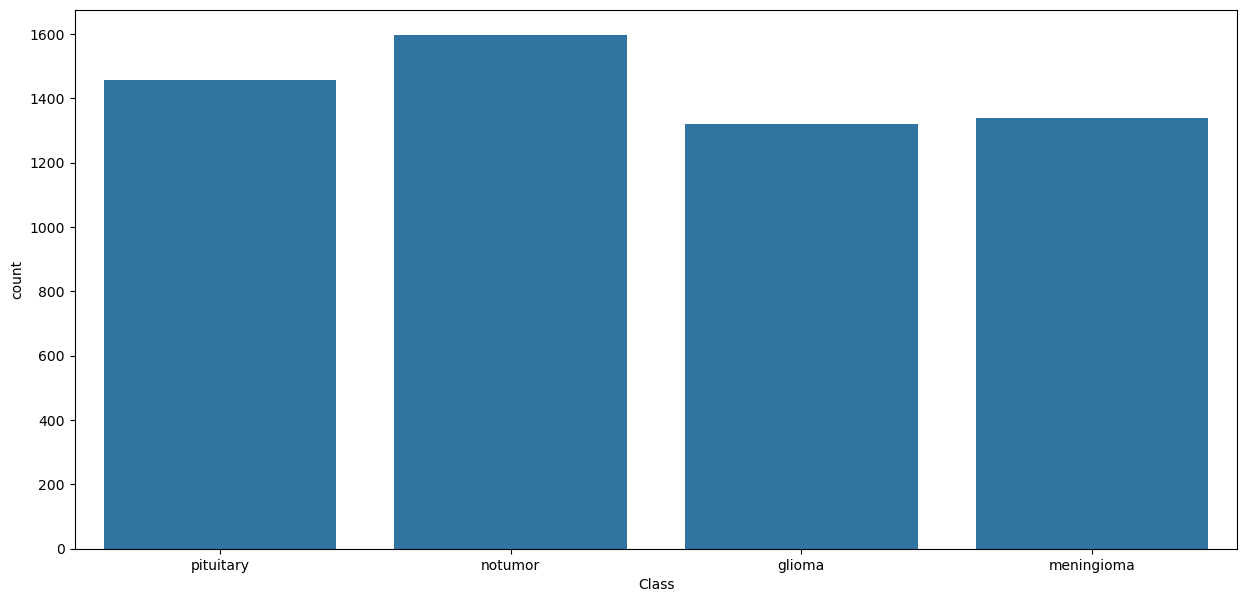

In [8]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df["Class"])

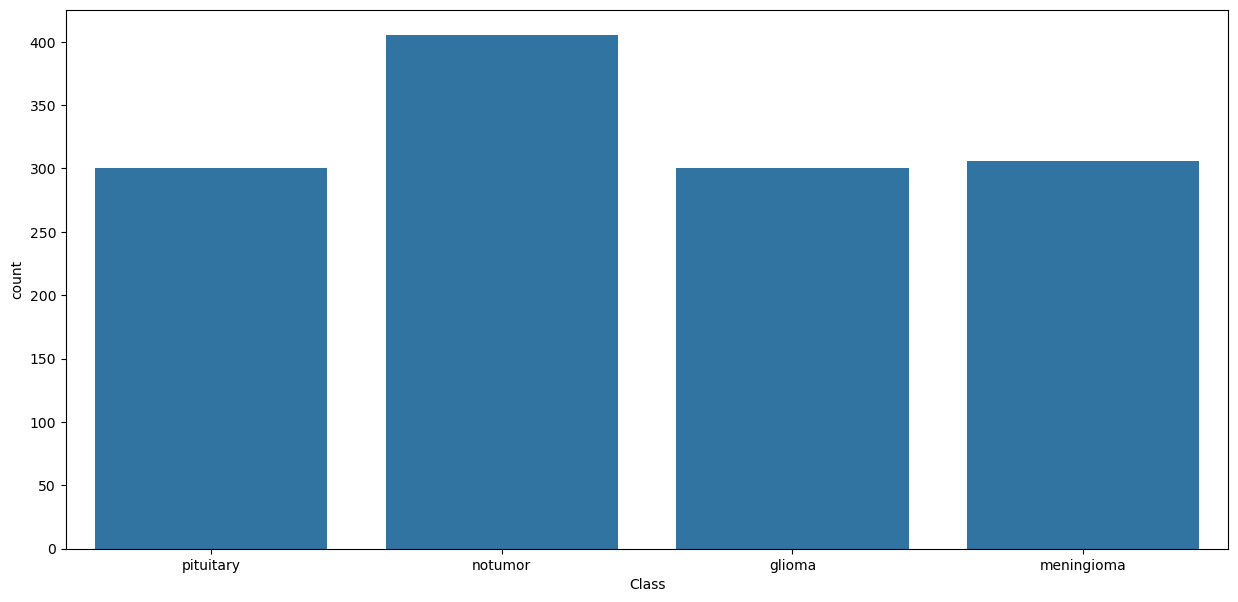

In [9]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df["Class"])

In [10]:
# !pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
632,Testing/notumor/Te-no_0267.jpg,notumor
186,Testing/pituitary/Te-pi_0072.jpg,pituitary
1093,Testing/meningioma/Te-me_0207.jpg,meningioma
798,Testing/glioma/Te-gl_0280.jpg,glioma
1066,Testing/meningioma/Te-me_0303.jpg,meningioma
...,...,...
1127,Testing/meningioma/Te-me_0176.jpg,meningioma
1087,Testing/meningioma/Te-me_0165.jpg,meningioma
602,Testing/notumor/Te-no_0162.jpg,notumor
1100,Testing/meningioma/Te-me_0164.jpg,meningioma


In [13]:
ts_df

,Class Path,Class
999,Testing/glioma/Te-gl_0074.jpg,glioma
1128,Testing/meningioma/Te-me_0189.jpg,meningioma
237,Testing/pituitary/Te-pi_0103.jpg,pituitary
1172,Testing/meningioma/Te-me_0218.jpg,meningioma
649,Testing/notumor/Te-no_0112.jpg,notumor
...,...,...
548,Testing/notumor/Te-no_0238.jpg,notumor
1187,Testing/meningioma/Te-me_0208.jpg,meningioma
981,Testing/glioma/Te-gl_0088.jpg,glioma
804,Testing/glioma/Te-gl_0191.jpg,glioma


In [14]:
batch_size = 32

img_size = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [15]:
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=16, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


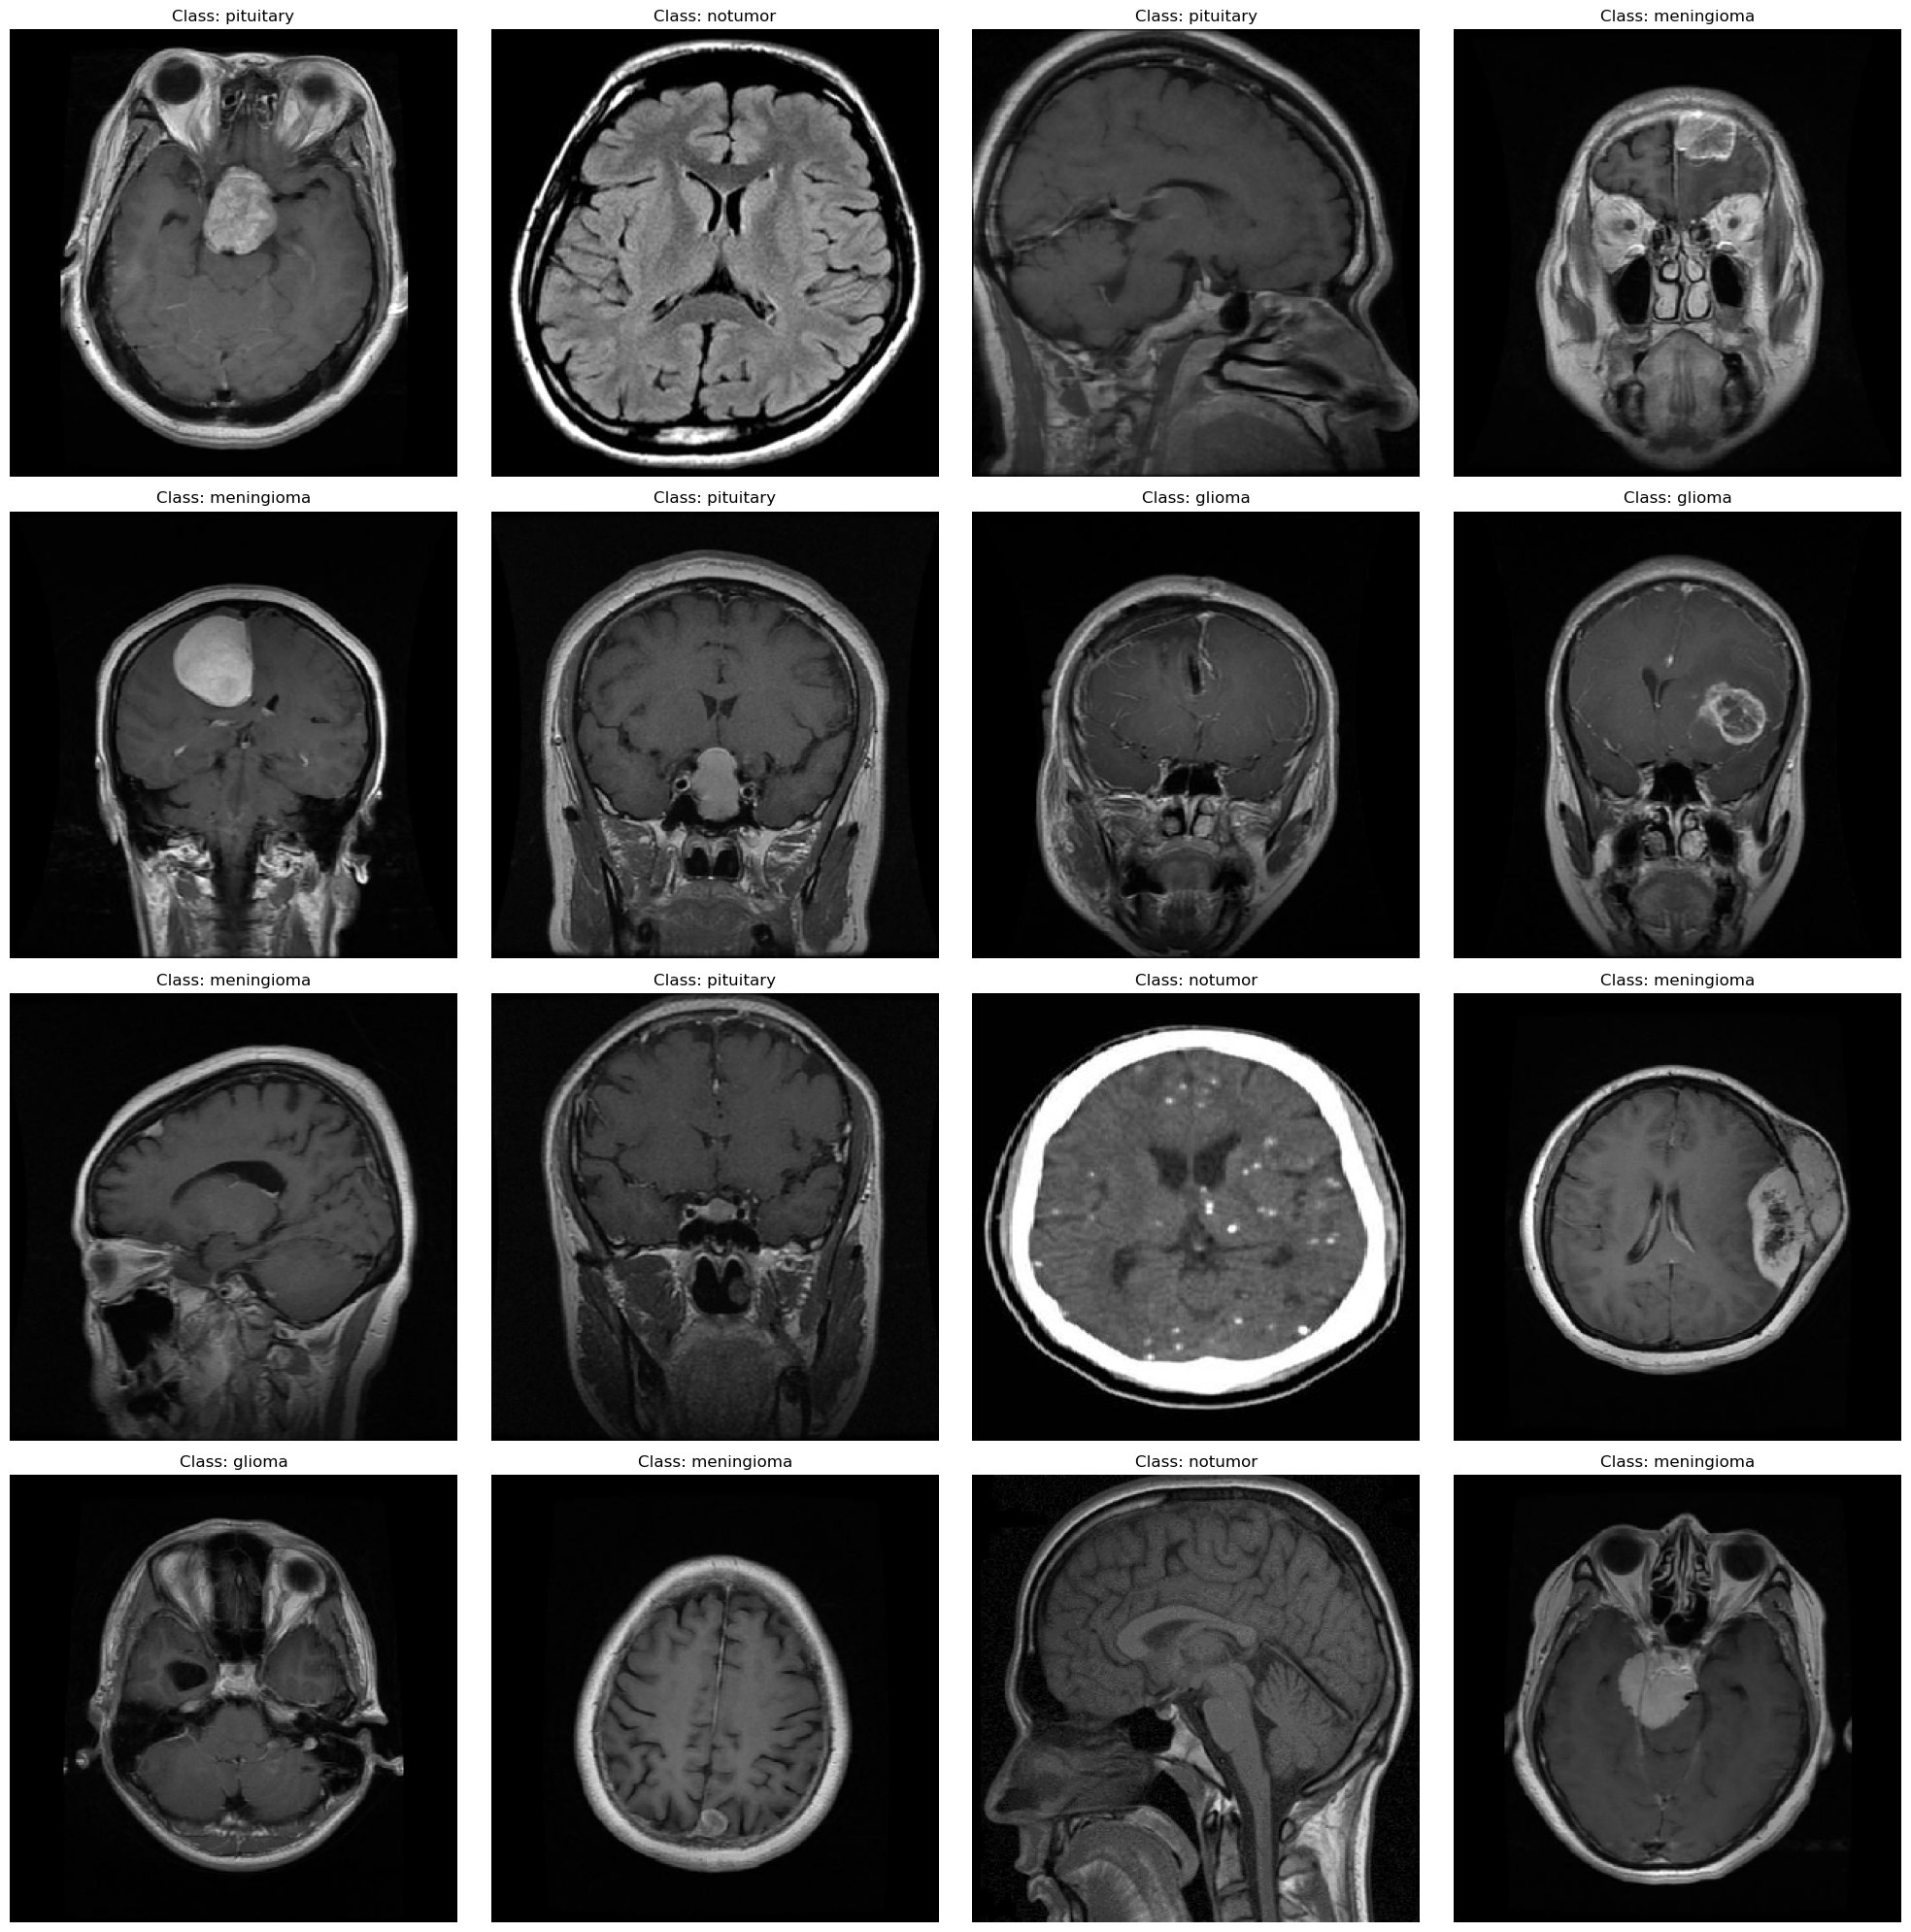

In [16]:
plt.figure(figsize=(20, 20))
for i in range (16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indeies
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape= img_shape, pooling='max')

model = Sequential([base_model, Flatten(), Dropout(rate= 0.3), Dense(128, activation= 'relu'), Dropout(rate= 0.25), Dense(4, activation= 'softmax')])

2024-11-07 21:44:28.421852: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-07 21:44:28.421903: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-07 21:44:28.421922: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-07 21:44:28.421952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 21:44:28.421972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

In [19]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/Users/paulc1/miniforge3/envs/tumor-classification/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-07 21:44:47.025430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


179/179 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7817 - loss: 0.6545 - precision: 0.8375 - recall: 0.6928 - val_accuracy: 0.9481 - val_loss: 0.1627 - val_precision: 0.9494 - val_recall: 0.9450
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9801 - loss: 0.0657 - precision: 0.9804 - recall: 0.9781 - val_accuracy: 0.9298 - val_loss: 0.1870 - val_precision: 0.9338 - val_recall: 0.9267
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9930 - loss: 0.0290 - precision: 0.9941 - recall: 0.9920 - val_accuracy: 0.9802 - val_loss: 0.0633 - val_precision: 0.9816 - val_recall: 0.9786
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9952 - loss: 0.0157 - precision: 0.9952 - recall: 0.9950 - val_accuracy: 0.9893 - val_loss: 0.0579 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9962 - loss: 0.0097 - precision: 0.9964 - recall: 0.9962 - val_accuracy: 0.9908 - val_loss: 0.0262 - val

In [20]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

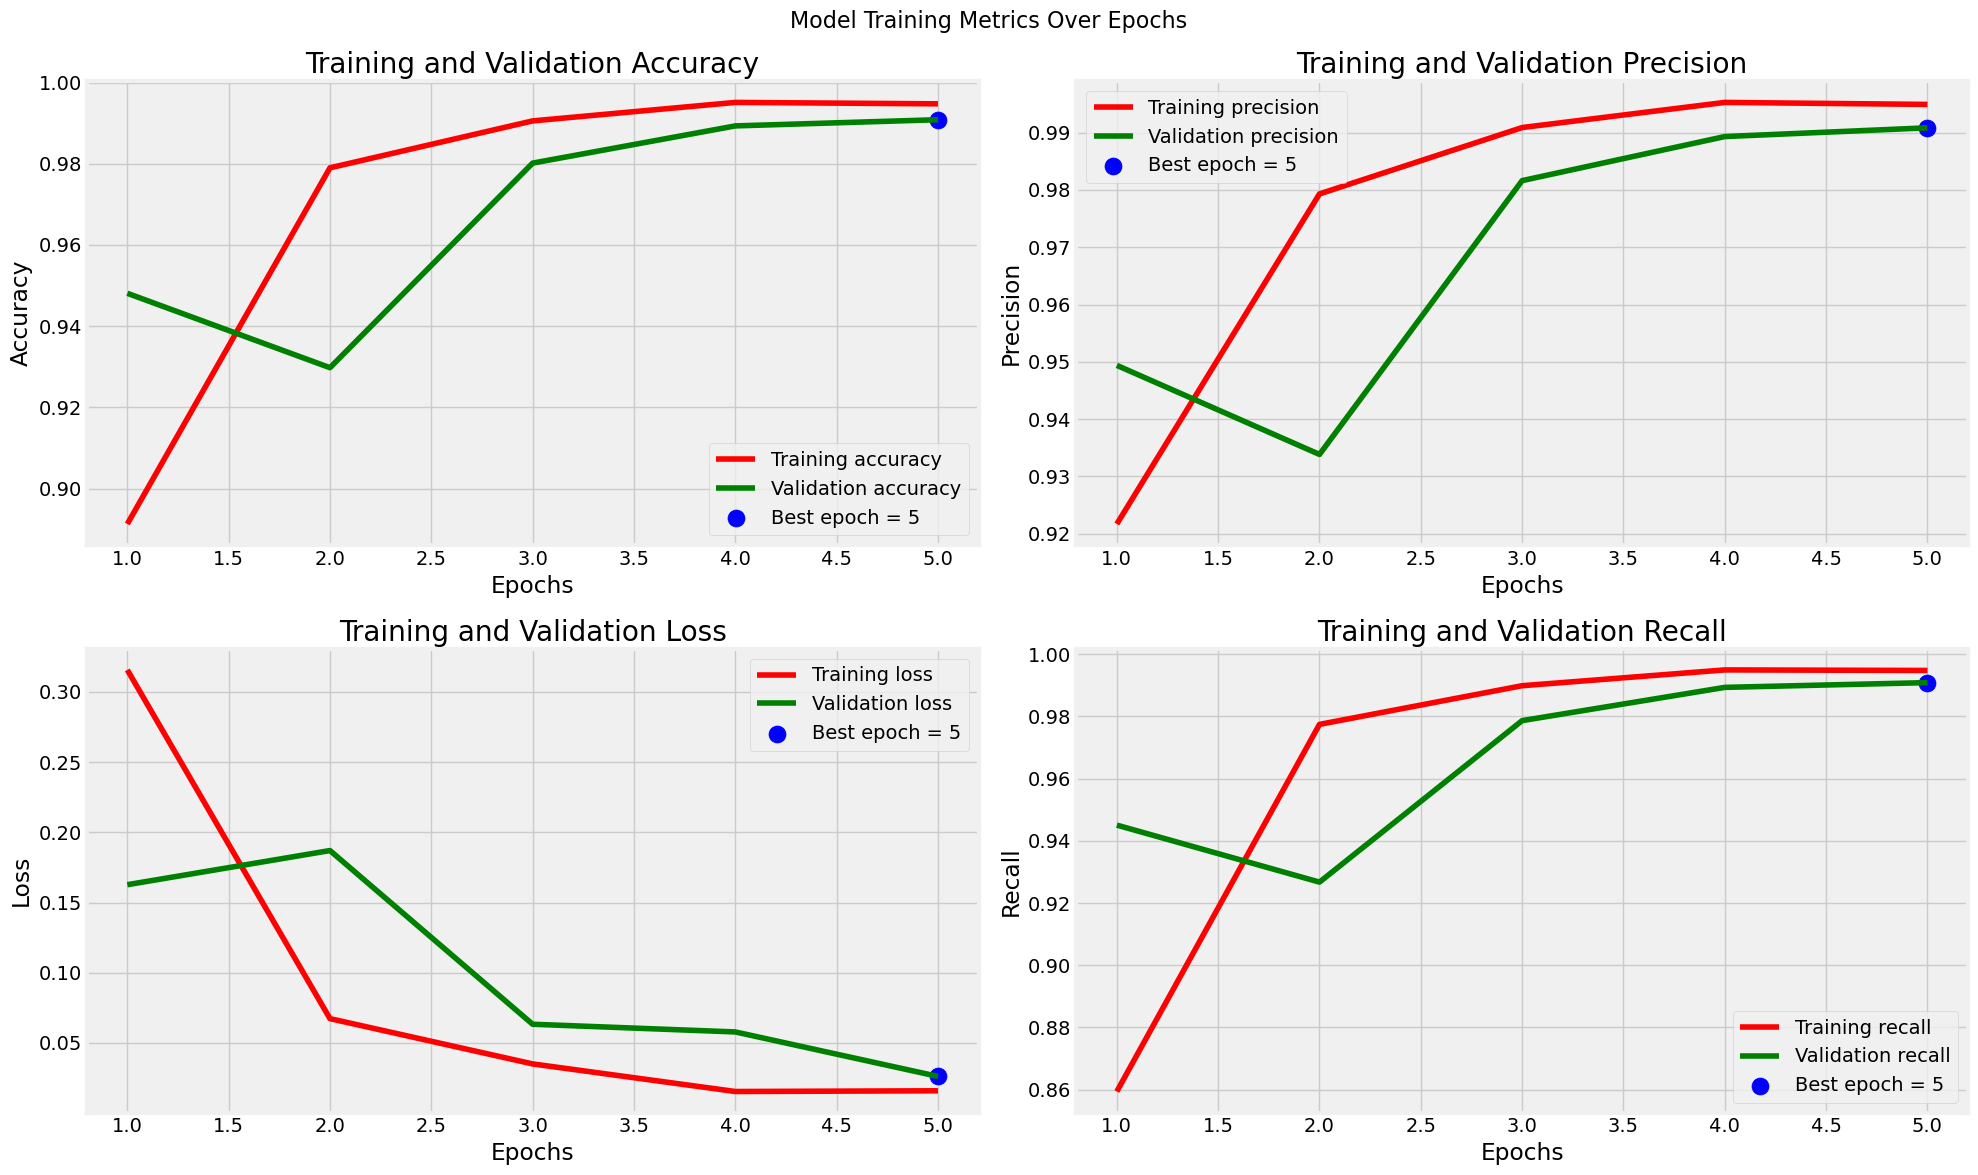

In [21]:
  # Get training and validation metrics from history
metrics = ['accuracy', 'precision', 'loss', 'recall']  
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)
    
    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', 
                label=f'Best epoch = {best_epochs[metric]}')
    
    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Training Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Testing Loss: {test_score[0]:.4f}")


179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 423ms/step - accuracy: 0.9959 - loss: 0.0112 - precision: 0.9960 - recall: 0.9957
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.9941 - loss: 0.0142 - precision: 0.9941 - recall: 0.9937


/Users/paulc1/miniforge3/envs/tumor-classification/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9854 - loss: 0.0817 - precision: 0.9854 - recall: 0.9854
Training Accuracy: 99.58%
Validation Loss: 0.0280


Validation Accuracy: 98.93%
Validation Loss: 0.0280


Test Accuracy: 98.63%
Testing Loss: 0.0486


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step


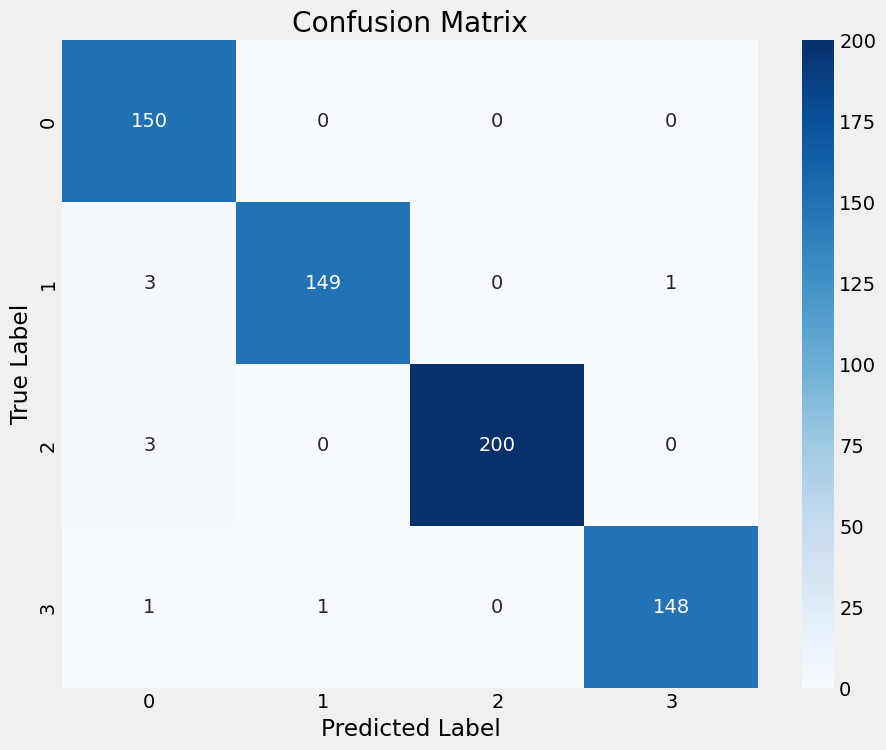

In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
  0: 'glioma',
  1: 'meningioma',
  2: 'no_tumor',
  3: 'pituitary'
}

# Then create a display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from PIL import Image

def predict(img_path: str) -> None:
  # Get class labels
  labels = list(class_dict.keys())

  # Load a process image
  img = Image.open(img_path)
  resized_image = img.resize((299, 299))
  img_array = np.asarray(resized_image)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get Predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_image)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


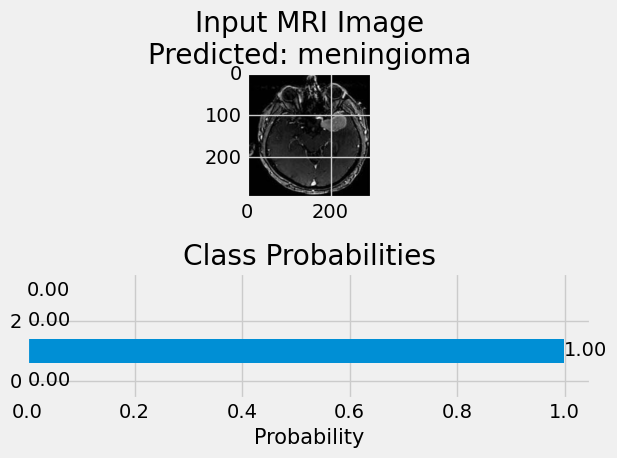


Predicted tumor type: meningioma


In [27]:
predict("Testing/meningioma/Te-me_0011.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


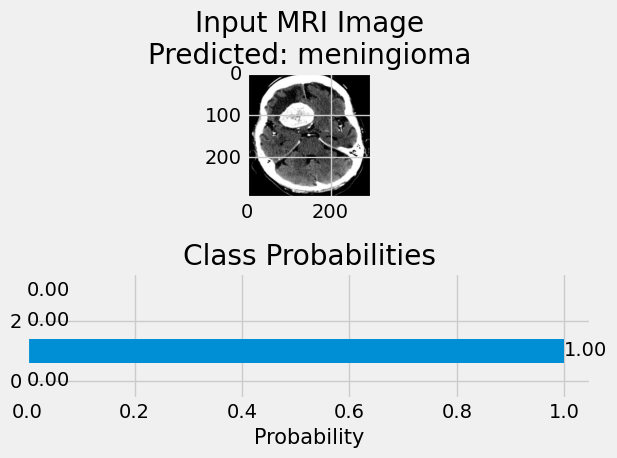


Predicted tumor type: meningioma


In [28]:
predict("Testing/meningioma/Te-me_0015.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


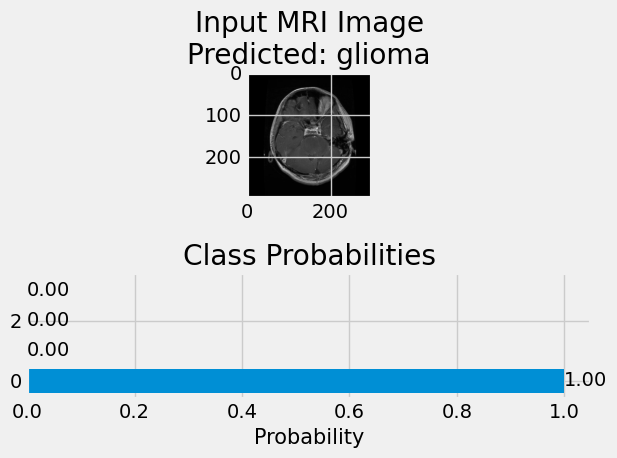


Predicted tumor type: glioma


In [29]:
predict("Testing/glioma/Te-gl_0010.jpg")

In [30]:
model.save_weights("xception_model.weights.h5")
